In [1]:
import os
import zipfile
import dotenv
import subprocess
import pandas as pd
from typing import Dict, Any
import json
import yaml
import time
import glob
import hashlib
import shutil
import logging
import pandas as pd


from PIL import Image
from transformers import pipeline
import torch

config_train = "config/UrbanElementsReID_train.yml"  # "config/UAM_containers.yml"
#config_test = "config/UrbanElementsReID_test.yml"
config_test = "config/UrbanElementsReID_test_reduced.yml"
competition_name = "urban-reid-challenge"
submission_message = f"test trained submission"
model_id_caption = "llava-hf/llava-1.5-7b-hf"


################ Probably nothing has to be modified from now on ################
dataset_path = os.path.join('assets', 'datasets', competition_name)
with open(config_train, 'r') as f:
    hyperparams_train = yaml.load(f, Loader=yaml.BaseLoader)
with open(config_test, 'r') as f:
    hyperparams_test = yaml.load(f, Loader=yaml.BaseLoader)
model_path = os.path.join(hyperparams_train['LOG_ROOT'], hyperparams_train['LOG_NAME'])
experiment_id: int = int(time.time())

assert dotenv.load_dotenv('../../.env')
assert os.getenv('KAGGLE_USERNAME')

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

logger = logging.getLogger()
logger.setLevel(logging.INFO)

device = f"cuda" if torch.cuda.is_available() else "cpu"
if device != "cuda":
    logging.warning("Where is your GPU dude?")

In [2]:
def calculate_params_hash(params: Dict[str, Any]) -> str:
    stringified = json.dumps({k: str(params[k]) for k in params}, sort_keys=True)
    return hashlib.md5(stringified.encode()).hexdigest()

# Downloads

In [ ]:
# TODO: move to .def
!pip install torch torchvision torchaudio einops timm scikit-image opencv-python tensorboard yacs kaggle pyyaml

# Download the dataset
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path, exist_ok=True)
    api.competition_download_files(competition_name, path="./assets")
    with zipfile.ZipFile(f'./assets/{competition_name}.zip', 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    os.remove(f'./assets/{competition_name}.zip')
    print(f"Downloaded dataset for {competition_name}")
    
    %cd assets/datasets/urban-reid-challenge
    !mv ./image_query/image_query/* ./image_query/
    !rm -r ./image_query/image_query
    
    !mv ./image_test/image_test/* ./image_test/
    !rm -r ./image_test/image_test
    
    !mv ./image_train/image_train/* ./image_train/
    !rm -r ./image_train/image_train
    %cd ../../..
else:
    print(f"Dataset already existed")

# Generate reduced dataset
'''
cp -r urban-reid-challenge/ urban-reid-challenge-reduced/
cd urban-reid-challenge-reduced/
for file in image_query/0*.jpg; do
    num=$(basename "$file" .jpg)  # Extract number
    num=$((10#$num))  # Convert to decimal
    if ((num > 3)); then
        rm "$file"
    fi
done
for file in image_test/0*.jpg; do
    num=$(basename "$file" .jpg)  # Extract number
    num=$((10#$num))  # Convert to decimal
    if ((num > 10)); then
        rm "$file"
    fi
done

sed -i '4q' query.csv
sed -i '11q' test.csv

''';


# Download the model
os.makedirs('assets/models', exist_ok=True)
if not os.path.exists('assets/models/resnet50-19c8e357.pth'):
    !curl -o "assets/models/resnet50-19c8e357.pth" "https://download.pytorch.org/models/resnet50-19c8e357.pth"
else:
    print('model already existed')
if not os.path.exists('assets/models/jx_vit_base_p16_224-80ecf9dd.pth'):
    !curl -L -o 'assets/models/jx_vit_base_p16_224-80ecf9dd.pth'  'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth'
else:
    print('model already existed')

# Train embedding model

In [136]:
!nvidia-smi

Fri Apr  4 02:20:49 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB           On  | 00000000:18:00.0 Off |                    0 |
| N/A   38C    P0              25W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [113]:
assert os.path.exists('assets'), 'are you are in the right folder?'
assert os.getcwd().endswith('PAT'), 'are you are in the right folder?'
if os.path.exists(model_path):
    shutil.rmtree(model_path)
!python train.py --config_file {config_train}

2025-04-04 02:00:49,419 PAT INFO: Saving model in the path :assets/models/PAT
2025-04-04 02:00:49,419 PAT INFO: Namespace(config_file='config/UrbanElementsReID_train.yml', opts=[], local_rank=0)
2025-04-04 02:00:49,419 PAT INFO: Loaded configuration file config/UrbanElementsReID_train.yml
2025-04-04 02:00:49,419 PAT INFO: 
MODEL:
  PRETRAIN_CHOICE: 'imagenet'
  #PRETRAIN_PATH: "../../.cache/torch/hub/checkpoints" # root of pretrain path
  PRETRAIN_PATH: "assets/models" 
  IF_LABELSMOOTH: 'on'
  IF_WITH_CENTER: 'no'
  NAME: 'part_attention_vit'
  NO_MARGIN: True
  DEVICE_ID: ('0')
  TRANSFORMER_TYPE: 'vit_base_patch16_224_TransReID'
  STRIDE_SIZE: [16, 16]

INPUT:
  SIZE_TRAIN: [256,128]
  SIZE_TEST: [256,128]
  REA:
    ENABLED: False
  PIXEL_MEAN: [0.5, 0.5, 0.5]
  PIXEL_STD: [0.5, 0.5, 0.5]
  LGT: # Local Grayscale Transfomation
    DO_LGT: True
    PROB: 0.5

DATASETS:
  TRAIN: ('UrbanElementsReID',)
  TEST: ('UrbanElementsReID',)
  #ROOT_DIR: ('../../data') # root of datasets
  #RO

In [ ]:
print(f'Backuped to {experiment_id}')
!cp -r {model_path} {model_path}_{experiment_id}

In [3]:
files = glob.glob(os.path.join(model_path, "part_attention_vit_*.pth"))
max_epoch = max([int(f.split('_')[-1].split('.')[0]) for f in files])
assert max_epoch > 0
assert os.path.exists(os.path.join(model_path, f'part_attention_vit_{max_epoch}.pth'))
print('max_epoch:', max_epoch)

max_epoch: 1


# Refine query images - Generate captions

In [2]:
!nvidia-smi

Fri Apr 11 13:29:44 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:81:00.0 Off |                  Off |
| N/A   33C    P0              35W / 250W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
from transformers import AutoProcessor, LlavaForConditionalGeneration

processor = AutoProcessor.from_pretrained(model_id_caption)
model = LlavaForConditionalGeneration.from_pretrained(model_id_caption, device_map="auto")

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
prompts = [
            "USER: <image>\nPlease describe this image\nASSISTANT:",
]

inputs = processor(prompts, images=[image1, image2], padding=True, return_tensors="pt").to("cuda")
for k,v in inputs.items():
  print(k,v.shape)

In [1]:
from transformers import pipeline

pipe = pipeline("image-text-to-text", model="llava-hf/llava-1.5-7b-hf")
pipe.processor.patch_size = 14
messages = [
    {
      "role": "user",
      "content": [
          {"type": "image", "url": "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/ai2d-demo.jpg"},
          {"type": "text", "text": "What does the label 15 represent? (1) lava (2) core (3) tunnel (4) ash cloud"},
        ],
    },
]

out = pipe(text=messages, max_new_tokens=20)
print(out)
#>>> [{'input_text': [{'role': 'user', 'content': [{'type': 'image', 'url': 'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/ai2d-demo.jpg'}, {'type': 'text', 'text': 'What does the label 15 represent? (1) lava (2) core (3) tunnel (4) ash cloud'}]}], 'generated_text': 'Lava'}]


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


[{'input_text': [{'role': 'user', 'content': [{'type': 'image', 'url': 'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/ai2d-demo.jpg'}, {'type': 'text', 'text': 'What does the label 15 represent? (1) lava (2) core (3) tunnel (4) ash cloud'}]}], 'generated_text': [{'role': 'user', 'content': [{'type': 'image', 'url': 'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/ai2d-demo.jpg'}, {'type': 'text', 'text': 'What does the label 15 represent? (1) lava (2) core (3) tunnel (4) ash cloud'}]}, {'role': 'assistant', 'content': ''}]}]


In [2]:
out[-1]['generated_text'][-1]

{'role': 'assistant', 'content': ''}

In [1]:
import requests
from PIL import Image
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

model_id = "llava-hf/llava-1.5-7b-hf"
revision = 'a272c74'
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    revision=revision, 
    torch_dtype=torch.float16, 
).to('cuda')
processor = AutoProcessor.from_pretrained(model_id, revision=revision)
processor.patch_size = 14

conversation = [
    {
      "role": "user",
      "content": [
          {"type": "text", "text": "What are these?"},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

image_file = "http://images.cocodataset.org/val2017/000000039769.jpg"
raw_image = Image.open(requests.get(image_file, stream=True).raw)
inputs = processor(images=raw_image, text=prompt, return_tensors='pt').to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


ER:  
What are these? ASSISTANT:


In [6]:
output[0]

tensor([    1,  3148,  1001, 29901, 29871, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 

In [8]:
!pip show torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: torch
Version: 2.6.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, auto_gptq, clean-fid, clip-anytorch, compel, dctorch, invisible-watermark, k-diffusion, kornia, lm_eval, lpips, peft, timm, torchaudio, torchdiffeq, torchmetrics, torchsde, torchvision


In [7]:
import sys
print(sys.version)

3.10.12 (main, Feb  4 2025, 14:57:36) [GCC 11.4.0]


In [4]:
!pip show transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: transformers
Version: 4.51.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: auto_gptq, compel, lm_eval, peft


In [4]:
pipe = pipeline("image-to-text", model=model_id_caption, revision='a272c74', device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
import requests
image_url = "https://imgs.search.brave.com/N9LI2IR4ywVCBkazNXrnWItJbz_b547NMZ_WQklsuCg/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly93d3cu/cGFyZW50cy5jb20v/dGhtYi91Nk9vS3Q1/TkM4dFNOcU4yRXZC/TGlYZEZJOFU9LzE1/MDB4MC9maWx0ZXJz/Om5vX3Vwc2NhbGUo/KTptYXhfYnl0ZXMo/MTUwMDAwKTpzdHJp/cF9pY2MoKS9kc3Nh/ZGYtOTYxNDNhNDkw/NjA3NGRlNWE4MGVl/ZjllZTFjYmE1Njgu/anBn"
question = "What is the color of the man's shirt?"
image = Image.open(requests.get(image_url, stream=True).raw)

In [6]:
prompt = "USER: <image>\nWhat is the color of the man's shirt?\nASSISTANT:"
outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
print(outputs[0]["generated_text"])

USER:  
What is the color of the man's shirt?
ASSISTANT:


In [7]:
outputs

[{'generated_text': "USER:  \nWhat is the color of the man's shirt?\nASSISTANT:"}]

In [2]:
#pipe = pipeline("image-text-to-text", model=model_id_caption)
pipe = pipeline("image-to-text", model=model_id_caption, device=device)
pipe.processor.patch_size = 14  # or whatever value is appropriate for your model
pipe.processor.vision_feature_select_strategy = "default"

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'patch_size'

In [3]:
df_query = pd.read_csv(os.path.join(hyperparams_test['DATASETS']['ROOT_DIR'], 'query.csv'))
df_query

,cameraID,imageName
0,c004,000001.jpg
1,c004,000002.jpg
2,c004,000003.jpg
3,c004,000001_refinement_A.jpg
4,c004,000002_refinement_A.jpg
5,c004,000003_refinement_A.jpg
6,c004,000002_refinement_B.jpg


In [4]:
if df_query['imageName'].str.contains('refinement').sum() > 0:
    logging.warning('This dataset was already refined, are you sure you want to proceed?')
    #raise ValueError()
    df_query = df_query[~df_query['imageName'].str.contains('refinement')]
df_query

,cameraID,imageName
0,c004,000001.jpg
1,c004,000002.jpg
2,c004,000003.jpg


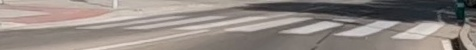

In [5]:
for index, row in df_query.iterrows():
    image = Image.open(os.path.join(hyperparams_test['DATASETS']['ROOT_DIR'], 'image_query', row['imageName']))
    #break
image

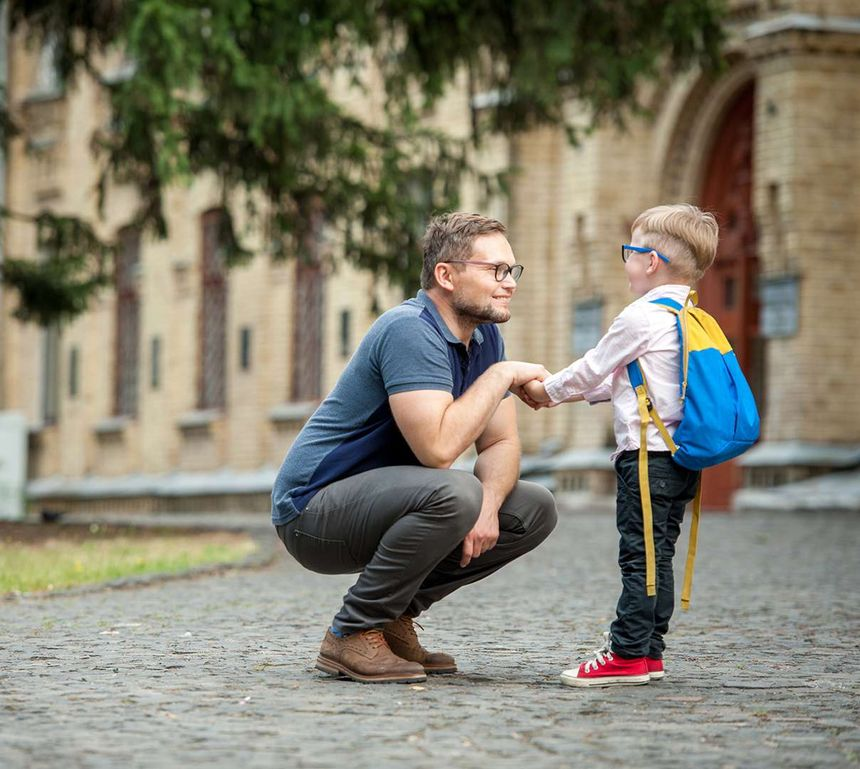

In [4]:
#image_url = "https://llava-vl.github.io/static/images/view.jpg"
#question = "What are the things I should be cautious about when I visit this place?"
import requests
image_url = "https://imgs.search.brave.com/N9LI2IR4ywVCBkazNXrnWItJbz_b547NMZ_WQklsuCg/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly93d3cu/cGFyZW50cy5jb20v/dGhtYi91Nk9vS3Q1/TkM4dFNOcU4yRXZC/TGlYZEZJOFU9LzE1/MDB4MC9maWx0ZXJz/Om5vX3Vwc2NhbGUo/KTptYXhfYnl0ZXMo/MTUwMDAwKTpzdHJp/cF9pY2MoKS9kc3Nh/ZGYtOTYxNDNhNDkw/NjA3NGRlNWE4MGVl/ZjllZTFjYmE1Njgu/anBn"
question = "What is the color of the man's shirt?"
#question = "What is the color of the child's shirt?"
#question = "Is the man wearing a rain jacket?"


image = Image.open(requests.get(image_url, stream=True).raw)
image


In [7]:
#!pip install transformers~=4.37

In [5]:
#question = "What is this?"
#outputs = pipe(image, text=f"USER: <image>\n{question}\nASSISTANT:", generate_kwargs={"max_new_tokens": 200})
#outputs = pipe(
#    [os.path.join(hyperparams_test['DATASETS']['ROOT_DIR'], 'image_query', row['imageName'])], 
#    text=[question], generate_kwargs={"max_new_tokens": 200})


max_new_tokens = 200
prompt = "USER: <image>\nWhat is the color of the man's shirt?\nASSISTANT:"

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})



print(outputs[0]["generated_text"])

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


USER:  
What is the color of the man's shirt?
ASSISTANT:


In [6]:
pipe.processor.patch_size = 14  # or whatever value is appropriate for your model
pipe.processor.vision_feature_select_strategy = "default"

question = "What is the color of the man's shirt?"
outputs = pipe(image, prompt=f"USER: <image>\n{question}\nASSISTANT:", generate_kwargs={"max_new_tokens": 400})
print(outputs[0]["generated_text"])

AttributeError: 'NoneType' object has no attribute 'patch_size'

In [16]:
outputs

[{'generated_text': "USER:  \nWhat is the color of the man's shirt?\nASSISTANT:"}]

In [17]:
!pip show transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: transformers
Version: 4.46.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: auto_gptq, compel, lm_eval, peft


# Refine query images - Generate images

for each image, generate refinements following naming like:
000001_refinement_A
000002_refinement_B
000002_refinement_C

save them in urban-reid-challenge-reduced/image_query/

Add those entires to urban-reid-challenge-reduced/image_query/query.csv

# Generate ranking

In [11]:

assert hyperparams_test['TEST']['WEIGHT'].split('/')[-1] == f'part_attention_vit_{max_epoch}.pth', 'not testing with the trained model...'

In [6]:
!python update.py --config_file {config_test} --track {os.path.join(model_path, "track.txt")}

2025-04-11 12:52:04,723 PAT INFO: Namespace(config_file='config/UrbanElementsReID_test_reduced.yml', opts=[], track='assets/models/PAT/track.txt')
2025-04-11 12:52:04,723 PAT INFO: Loaded configuration file config/UrbanElementsReID_test_reduced.yml
2025-04-11 12:52:04,723 PAT INFO: 
MODEL:
  PRETRAIN_CHOICE: 'imagenet'
  #PRETRAIN_PATH: "../../.cache/torch/hub/checkpoints" # root of pretrain path
  PRETRAIN_PATH: "assets/models" 
  METRIC_LOSS_TYPE: 'triplet'
  IF_LABELSMOOTH: 'on'
  IF_WITH_CENTER: 'no'
  NAME: 'part_attention_vit'
  NO_MARGIN: True
  DEVICE_ID: ('0')
  TRANSFORMER_TYPE: 'vit_base_patch16_224_TransReID'
  STRIDE_SIZE: [16, 16]

INPUT:
  SIZE_TRAIN: [256,128]
  SIZE_TEST: [256,128]
  REA:
    ENABLED: False
  PIXEL_MEAN: [0.5, 0.5, 0.5]
  PIXEL_STD: [0.5, 0.5, 0.5]
  LGT: # Local Grayscale Transfomation
    DO_LGT: True
    PROB: 0.5

DATASETS:
  TRAIN: ('UrbanElementsReID',)
  TEST: ('UrbanElementsReID_test',)
  #ROOT_DIR: ('../../data') # root of datasets
  #ROOT_DIR

In [18]:
submission_file_name = os.path.join(model_path, "track_submission.csv")
assert os.path.exists(submission_file_name)

In [ ]:
!cp -r {model_path} {model_path}_backup_{experiment_id}

# Submission

In [133]:
assert os.path.exists(submission_file_name)
df = pd.read_csv(submission_file_name)
assert df.shape[1] == 2
assert df.shape[0] > 100

submission_message += f"; commit_hash: {subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()}"
submission_message += f"; hyperparameters_hash: {calculate_params_hash(hyperparams_train)}"
submission_message += f"; experiment_ID: {experiment_id}"
print(f'Submitting with message "{submission_message}"')

# Submit the file to the competition
# Uncomment only for actual submissions!
#api.competition_submit(submission_file_name, submission_message, competition_name)    